In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

tfd = tfp.distributions
tfpl = tfp.layers

2023-04-30 00:06:51.150050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


https://www.youtube.com/watch?v=KJxmC5GCWe4

TFP docs are [here](https://www.tensorflow.org/probability/api_docs/python/tfp)

# Modeling aleatoric and epistemic uncertainty using TensorFlow and TensorFlow Probability

## PyData Global 2021

Modeling uncertainty is incredibly useful when we want to understand how sure the model is about its own predictions. In the talk we’ll discuss differences between two types of uncertainty (aleatoric and epistemic) and show how to model them using TensorFlow and TensorFlow Probability. At the end of the talk, you’ll have practical understanding how to apply uncertainty modeling in your own project.


Prerequisites:

* Have good understanding of deep learning basics
* Have good understanding of Bayes’ theorem
* Have practical experience in a contemporary Python deep learning framework (TensorFlow recommended)


## 1. TFP Components: `tfp.distributions`

In [2]:
# Let's start with Normal(100, 15)
normal = tfd.Normal(loc=100., scale=15.)

In [3]:
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

### 1.1 Methods -  `.sample()`

In [4]:
# Draw 2000 samples form `normal`
samples = normal.sample(2000)
samples.numpy()

array([ 78.942154, 138.1165  , 115.35555 , ..., 117.21188 ,  82.47388 ,
        90.99155 ], dtype=float32)

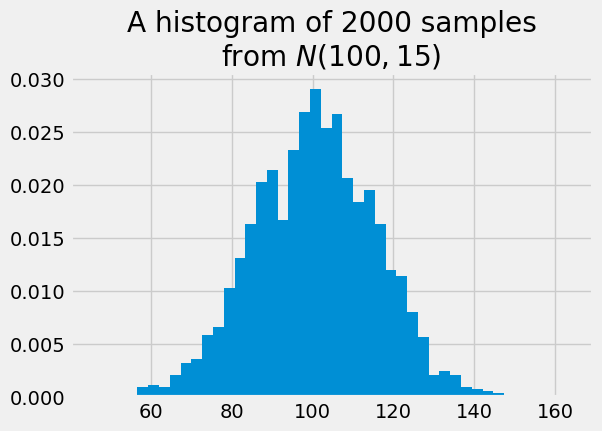

In [5]:
# Plot a histogram of `samples`
plt.figure(figsize=(6, 4))
plt.hist(samples.numpy(), density=True, bins=np.sqrt(2000).astype(int))
plt.title('A histogram of 2000 samples\nfrom $N(100, 15)$')
plt.show()

### 1.2 Methods -  `.prob()` & `.log_prob()`

In [6]:
# Let's compare PDF values of a couple of values given `normal`
values = [70., 85., 100., 115., 130.]

for v in values:
    print(f'PDF of {v:05.1f} == {normal.prob(v):.4f}')

PDF of 070.0 == 0.0036
PDF of 085.0 == 0.0161
PDF of 100.0 == 0.0266
PDF of 115.0 == 0.0161
PDF of 130.0 == 0.0036


In [7]:
# Now, let's do the same for log_probs
values = [70., 85., 100., 115., 130.]

for v in values:
    print(f'Log PDF {v:05.1f} == {normal.log_prob(v):.4f}')

Log PDF 070.0 == -5.6270
Log PDF 085.0 == -4.1270
Log PDF 100.0 == -3.6270
Log PDF 115.0 == -4.1270
Log PDF 130.0 == -5.6270


## 2. Modeling aleatoric uncertainty - `tfp.layers`

### 2.1 `tfpl.MultivariateNormal` layer

#### 2.1.1 Generate data

First, let's generate some data! 

Our data generating process will be defined by the following formula:

$$\large y_i = 1.5x_i + 3 + 0.35\epsilon$$

where:

* $\epsilon \sim N(0, 1)$

In [8]:
# Generate the data
x_train = np.linspace(-1, 1, 200)[:, np.newaxis]
y_train = 1.5*x_train + 3 + 0.35*np.random.randn(200)[:, np.newaxis]

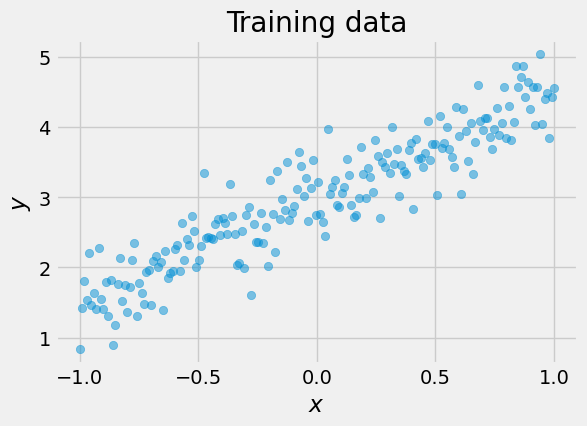

In [9]:
# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data')
plt.show()

#### 2.1.2 Simple model

In [10]:
# Let's build a simple linear regression model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])

# Compile 
model.compile(loss='mse', optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=100, verbose=0)

In [11]:
# Predict
y_pred = model(x_train)

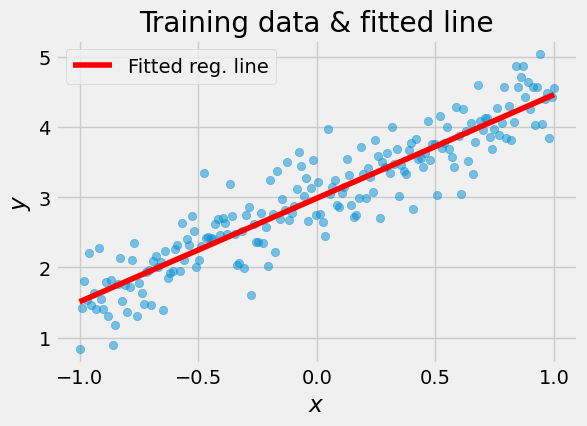

In [12]:
# Plot the data and a trained regression line
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.plot(x_train, y_pred, label='Fitted reg. line', c='r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted line')
plt.legend()
plt.show()

#### 2.1.3 Model with probabilistic output - aleatoric uncertainty (learn mean & std)

In [13]:
# Let's build a model with probabilistic output (mean & std) - a simple way
event_shape = 1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1,)),
    tfpl.IndependentNormal(event_shape=event_shape)
])

# Define neg. loglik. loss function
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile 
model.compile(loss=neg_loglik, optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=300, verbose=0)

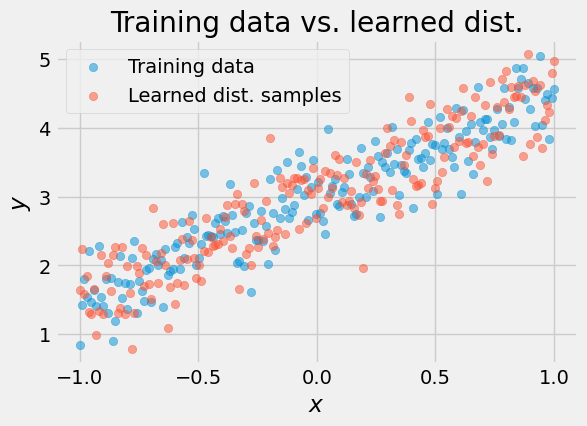

In [14]:
# Let's compare distributions - y_train & y_model
y_model = model(x_train).sample().numpy()

# Plot 
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5, label='Training data')
plt.scatter(x_train, y_model, alpha=.5, label='Learned dist. samples')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Training data vs. learned dist.')
plt.show()

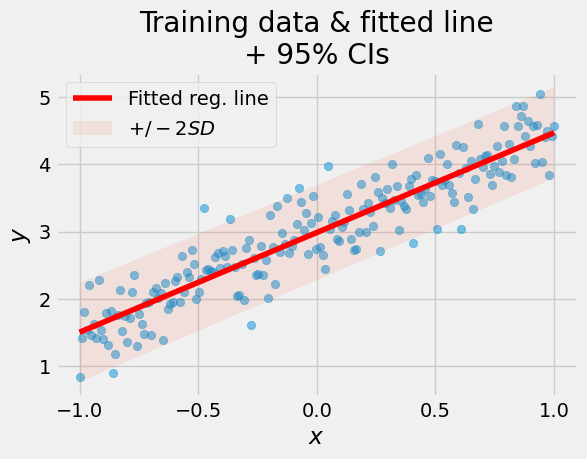

In [15]:
# Compute conf ints
y_sample = model(x_train).sample()
y_hat = model(x_train).mean()
y_sd = model(x_train).stddev()
y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

# Plot conf ints
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.plot(x_train, y_hat, label='Fitted reg. line', c='r')
plt.fill_between(np.squeeze(x_train), np.squeeze(y_hat_lower), np.squeeze(y_hat_upper), alpha=.1, label='$+/- 2SD$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted line\n+ 95% CIs')
plt.legend()
plt.show()

## 3. Modeling epistemic uncertainty - `tfpl.DenseVariational`

Now, we're going to model weight's uncertainty. 

This means, that each weight in our network will now be represented by a **distribution**, and **not** just a **point estimate**.

<br><br>

<img src="https://sanjaykthakur.files.wordpress.com/2018/12/bayes_nn.png">
<p style="text-align: center"><sup>Image from <a href="https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/">https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/</a></sup></p>

<br><br>

To do this we'll use **Bayes by Backprop** method introduced in a Blundell et al. paper [Weight uncertainty in neural networks](https://arxiv.org/pdf/1505.05424.pdf) (2015).

<br>

We'll try to estimate weight distribution parameters $\theta$, given data $D$:


$$\large P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$


We'll follow a three-step formula to achieve this:

1. Pick a prior density over weights $P(\theta)$
2. Use training data $D$ to determine the likelihood $P(D | \theta)$
3. Estimate the posterior density over weights $P(\theta | D)$ 

<br>

Keywords: [***KL divergence***](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [***ELBO***](https://en.wikipedia.org/wiki/Evidence_lower_bound), [***reparametrization trick***](https://arxiv.org/pdf/1505.05424.pdf)

### 3.1 Epistemic uncertainty - linear case

In [16]:
# Let's start with our linear data!
x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]

y_train_100 = 1.5*x_train_100 + 3 + 0.35*np.random.randn(100)[:, np.newaxis]
y_train_1000 = 1.5*x_train_1000 + 3 + 0.35*np.random.randn(1000)[:, np.newaxis]

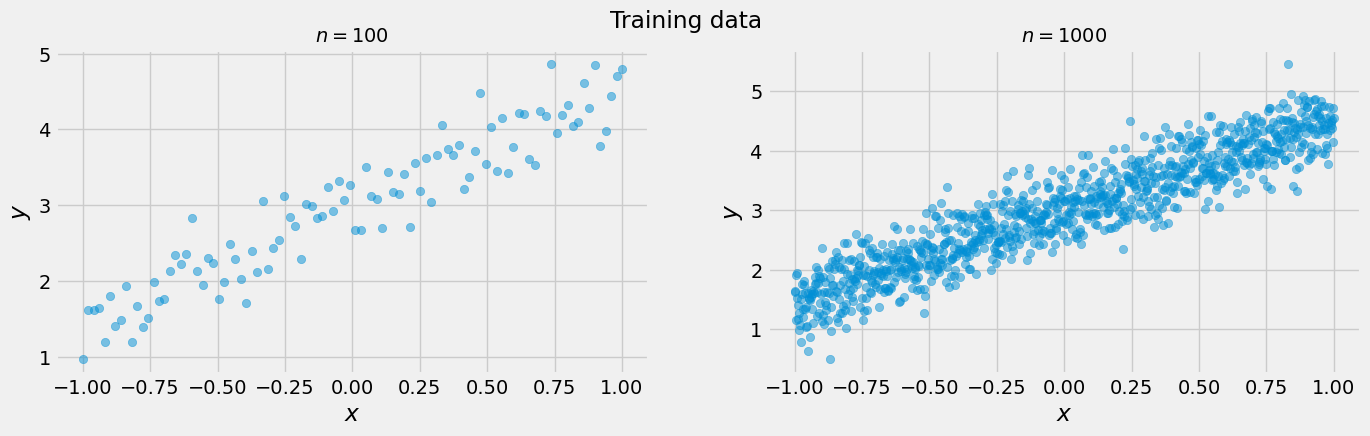

In [17]:
# Plot the data
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.scatter(x_train_100, y_train_100, alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)

plt.subplot(122)
plt.scatter(x_train_1000, y_train_1000, alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)

plt.suptitle('Training data')
plt.show()

#### 3.1.1 Define prior and posterior

`prior()` and `posterior()` functions are necessary to parametrize `tfpl.DenseVariational` layer.

They both need to take `kernel_size`, `bias_size` and `dtype` arguments.

In [18]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

#### 3.1.2 Aleatoric uncertainty - define a model with `DenseVariational` layer

In [19]:
# Define the model
def get_aleatoric_model(x_train_shape):
    
    model = tf.keras.Sequential([
        tfpl.DenseVariational(
            1,
            input_shape=(1,),
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1/x_train_shape, # Normalizing to scale the D_KL term in ELBO properly when using minibatches.
            kl_use_exact=False) # could be `True` in this case, but we go for estimated value
    ])

    # Compile
    model.compile(loss='mse', optimizer='sgd')
    
    return model

# Initialize
model = get_aleatoric_model(100)

In [20]:
# Fit the model on two datasets 
print('Fitting `model_100`...')
model_100 = get_aleatoric_model(100)
history_100 = model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

print('Fitting `model_1000`...')
model_1000 = get_aleatoric_model(1000)
history_1000 = model_1000.fit(x_train_1000, y_train_1000, epochs=500, verbose=False)

print('Done.')

Fitting `model_100`...
Fitting `model_1000`...
Done.


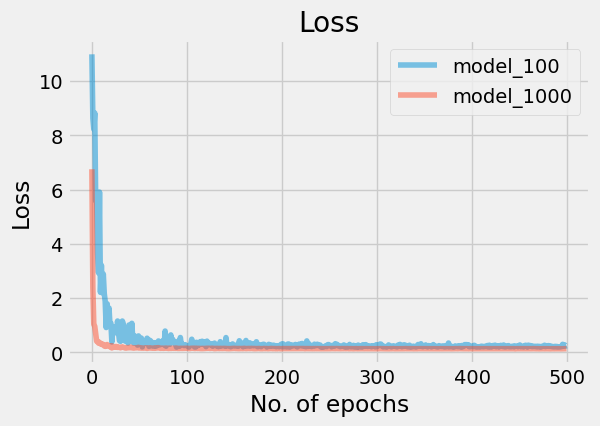

In [21]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history_100.history['loss'], label='model_100', alpha=.5)
plt.plot(history_1000.history['loss'], label='model_1000', alpha=.5)
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

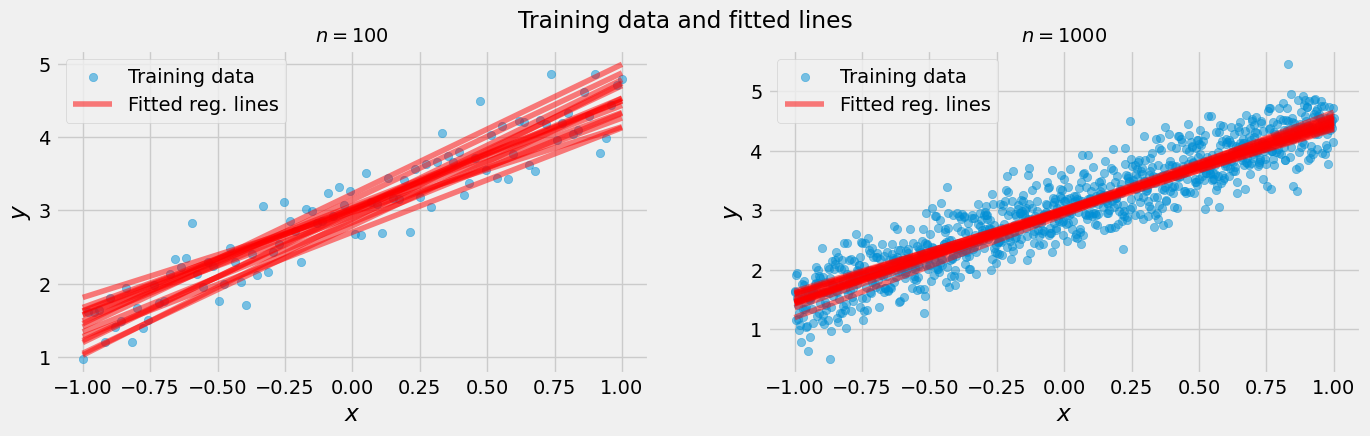

In [22]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(15, 4))

#------------------------------

plt.subplot(121)
plt.scatter(x_train_100, y_train_100, alpha=.5, label='Training data')
for _ in range(N_ITERS):
    y_model_100 = model_100(x_train_100)
    if _ == 0:
        plt.plot(x_train_100, y_model_100, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(x_train_100, y_model_100, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)
plt.legend()

#------------------------------

plt.subplot(122)
plt.scatter(x_train_1000, y_train_1000, alpha=.5, label='Training data')
for _ in range(N_ITERS):
    y_model_1000 = model_1000(x_train_1000)
    if _ == 0:
        plt.plot(x_train_1000, y_model_1000, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(x_train_1000, y_model_1000, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)
plt.legend()

#------------------------------

plt.suptitle('Training data and fitted lines')
plt.show()

## 4. Going fully probabilistic: aleatoric & epistemic uncertainty

### 4.1 Fully probabilistic non-linear case 

In [23]:
# Create non-linear data
n_samples = int(5e3)
x_train = np.linspace(-1, 1, n_samples)[:, np.newaxis]
y_train = x_train**3 + 0.1*(1.5 + x_train)*np.random.randn(n_samples)[:, np.newaxis]

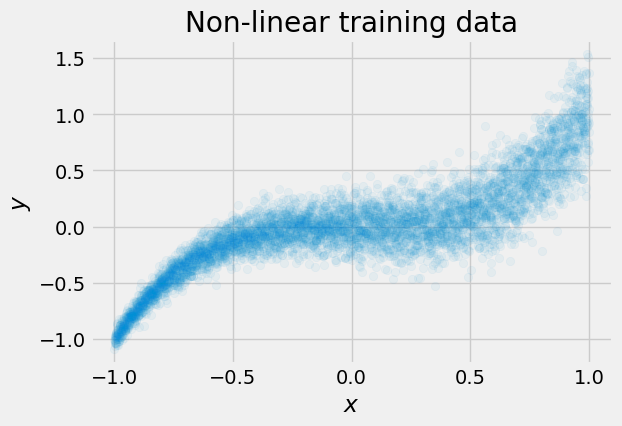

In [24]:
# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=0.05)
plt.title('Non-linear training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [25]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

In [26]:
# Define the model
def get_full_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=8,
                              input_shape=(1,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [27]:
# Get the model
model_full = get_full_model(n_samples)

In [28]:
%%time
# Initialize the model
model_full = get_full_model(n_samples)

# Fit
history = model_full.fit(x_train, y_train, epochs=1000, verbose=0)

CPU times: user 5min 38s, sys: 1min, total: 6min 39s
Wall time: 3min 17s


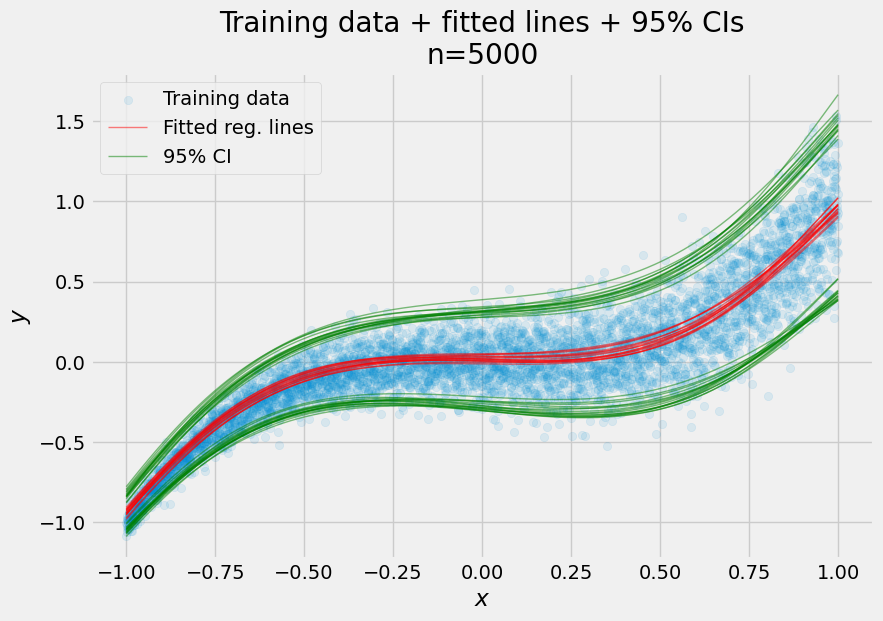

In [29]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_train).sample()
    y_hat = model_full(x_train).mean()
    y_sd = model_full(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()